In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
from flowpm.tfpower import linear_matter_power
from flowpm.tfbackground import a_of_chi,rad_comoving_distance
from flowpm.raytracing import  lightcone, Born, wlen
from flowpm.cosmology import Planck15
from flowpm.tfpower import linear_matter_power
import flowpm.constants as constants
import flowpm
from astropy.io import fits

Populating the interactive namespace from numpy and matplotlib


In [2]:
nc=[64,64,640]            # size of the cube, number of cells
nc_xy= 64                # number of pixel for x and  y 
Boxsize=[200,200,2000]    # Physical size of the cube

In [3]:
#To make lens planes of size 200 Mpc/h :
cosmo = Planck15()
r = np.linspace(0,2000,11, endpoint=True)
r_center = 0.5*(r[1:] + r[:-1])
a = a_of_chi(cosmo, r)
a_center = a_of_chi(cosmo, r_center)

In [4]:
r

array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
       1800., 2000.])

In [5]:
r_center

array([ 100.,  300.,  500.,  700.,  900., 1100., 1300., 1500., 1700.,
       1900.])

In [6]:
a

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([0.9989269 , 0.93663925, 0.87867343, 0.8259847 , 0.777372  ,
       0.7319877 , 0.6901339 , 0.6509547 , 0.6141374 , 0.57941747,
       0.5465707 ], dtype=float32)>

Text(0.5, 0, 'Mpc/h')

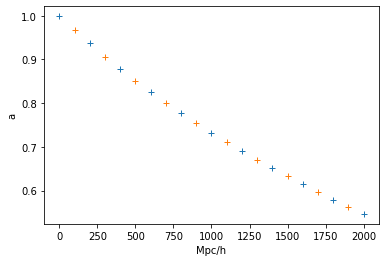

In [7]:
# This allows us to go to roughly z=1
plot(r,a, '+')
plot(r_center,a_center, '+')
ylabel(r'a')
xlabel(r'Mpc/h')

In [8]:
# We will first run the simulation to the lowest scaler factor entering the lightcone
init_stages = tf.linspace(0.1, a[-1], 4)
initial_conditions = flowpm.linear_field(nc,    
                                            Boxsize, 
                                             lambda k: tf.cast(linear_matter_power(cosmo, k), tf.complex64),         
                                             batch_size=1)
# Sample particles
state = flowpm.lpt_init(cosmo, initial_conditions, 0.1)   
# Evolve particles down to z=0
med_state = flowpm.nbody(cosmo, state, init_stages, nc)         
# Retrieve final density field
med_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), med_state[0])

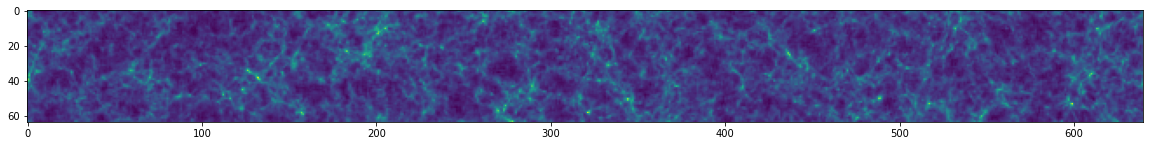

In [9]:
# At this stage we are at the right edge of the lightcone
figure(figsize=[20,5])
imshow(tf.reshape(med_field, nc).numpy().sum(axis=0))

In [14]:
import numpy as np
import tensorflow as tf
import flowpm
from flowpm.tfbackground import rad_comoving_distance
from flowpm.tfpm import kick, drift, force
import flowpm.constants as constants


def lightcone(
    cosmo,
    state,
    stages,
    nc,
    plane_resolution,  # in arcmin
    plane_size,  # in pixels
    pm_nc_factor=1,
    name="NBody"):
  """
  Integrate the evolution of the state across the givent stages

  Parameters:
  -----------
  cosmo: cosmology
    Cosmological parameter object

  state: tensor (3, batch_size, npart, 3)
    Input state

  stages: array
    Array of scale factors, also define slices in the volume

  nc: int
    Number of cells

  pm_nc_factor: int
    Upsampling factor for computing

  Returns
  -------
  state: tensor (3, batch_size, npart, 3)
    Integrated state to final condition
  """
  with tf.name_scope(name):
    state = tf.convert_to_tensor(state, name="state")

    shape = state.get_shape()
    batch_size = shape[1]

    nstages, = stages.shape

    # Unrolling leapfrog integration to make tf Autograph happy
    if nstages == 0:
      return state

    ai = stages[0]

    # first force calculation for jump starting
    state = force(cosmo, state, nc, pm_nc_factor=pm_nc_factor)
    nx = nc[0]
    nz = nc[2]
    lps = []
    lps_a = []
    snapshots = []
    w = 64

    x, p, f = ai, ai, ai
    # Loop through the stages
    for i in range(nstages - 1):
      a0 = stages[i]
      a1 = stages[i + 1]
      ah = (a0 * a1)**0.5

      # Kick step
      state = kick(cosmo, state, p, f, ah)
      p = ah

      # Drift step
      state = drift(cosmo, state, x, p, a1)
      x = a1

      # Access the positions of the particles
      pos = state[0]
      d = pos[:, :, 2]

      # Compute density plane in sky coordinates around the center of the lightcone
      # TODO: Confirm conversion from comoving distances to angular size! I thought
      # we should be using the angular diameter distance, but as far as I can see
      # everyone uses the transverse comoving distance, and I don't understand exactly why
      lens_plane = tf.zeros([batch_size, plane_size, plane_size])

      # Selecting only the particles contributing to the lens plane
      s = tf.gather(state, tf.where((d[0] > (nz - (i + 1) * w)) & (d[0] <= (nz - i * w)))[:,0], axis=2) 
      # NOTES!!! IT WILL ONLY WORK FOR BATCH 1
        
      # This is the transverse comoving distance inside the box
      xy = s[0, :, :, :2] 
      d = s[0, :, :, 2]
      # Apply periodic conditions 
      xy = tf.math.mod(xy, nx)
      
      # Convert coordinates to angular coords, and then into plane coords
      # xy = (xy / tf.expand_dims(d, -1)) / np.pi * 180 * 60 / plane_resolution
    
      xy = xy / nx * plane_size
    
      # mask = tf.where((d > (nz - (i + 1) * w)) & (d <= (nz - i * w)), 1., 0.)
        
      # And falling inside the plane, NOTE: This is only necessary on CPU, on GPU
      # cic paint 2d can be made to work with non periodic conditions.
      mask = tf.where(
          (xy[..., 0] > 0) & (xy[..., 0] < plane_size), 1., 0.)
      mask = mask * tf.where(
          (xy[..., 1] > 0) & (xy[..., 1] < plane_size), 1., 0.)
      # Compute lens planes by projecting particles
      lens_plane = flowpm.utils.cic_paint_2d(lens_plane, xy,
                                             mask)
      # Subtracting mean: Is this the right thing to do???
      #lens_plane = lens_plane - tf.reduce_mean(lens_plane, axis=[1,2], keepdims=True)
      #
      lps.append(lens_plane)
      lps_a.append(a1)

      # Here we could trim the state vector for particles originally beyond the current lens plane
      # This way the simulation becomes smaller as it runs and we save resources
      #s = tf.reshape(state, [3, batch_size, nc[0], nc[1], -1, 3])
      #s = s[:, :, :, :, (nz - (i + 1) * w):(nz - i * w), :]  #- tf.constant([0.,0.,(nz - (i + 1) * w)])
      #print(i, (nz - (i + 1) * w), (nz - i * w))
      snapshots.append(s)#tf.reshape(s, [3, batch_size, -1, 3]))

      # Force
      state = force(cosmo, state, nc, pm_nc_factor=pm_nc_factor)
      f = a1

      # Kick again
      state = kick(cosmo, state, p, f, a1)
      p = a1

    return state, lps_a, lps, snapshots

In [15]:
a_cen = np.concatenate([a_center.numpy(),np.array([a[-1]])])

In [16]:
nc_xy=64
res = 5.*60/64
final_state, lps_a, lps, snaps = lightcone(cosmo, med_state, a_cen[::-1], 
                                    nc, 
                                    res, nc_xy)

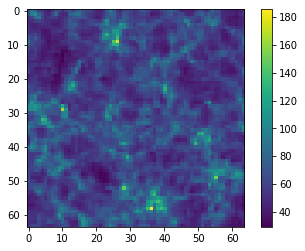

In [17]:
imshow(lps[0][0]); colorbar()

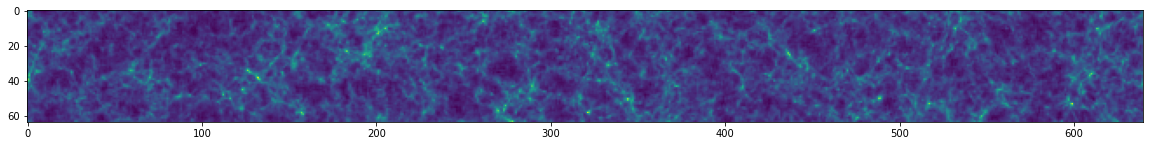

In [18]:
# At this stage we are at the right edge of the lightcone
figure(figsize=[20,5])
imshow(tf.reshape(med_field, nc).numpy().sum(axis=0))

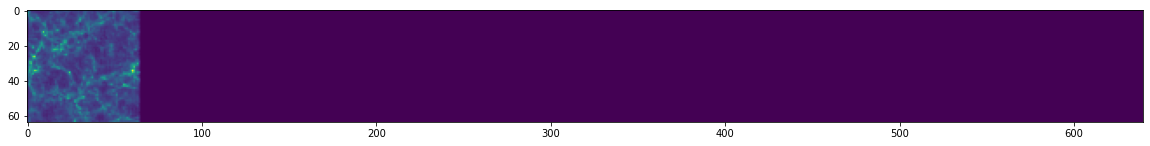

In [19]:
#Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), snaps[9][0])

# And this is what remains of the simulation at redhift=0 
figure(figsize=[20,5])
imshow(tf.reshape(final_field, [64,64,-1]).numpy().sum(axis=0))

In [20]:
lps_a

[0.56277263,
 0.5965301,
 0.6322684,
 0.67023087,
 0.7107043,
 0.754423,
 0.8012045,
 0.8517828,
 0.9067391,
 0.96756494]

In [21]:
a_cen

array([0.96756494, 0.9067391 , 0.8517828 , 0.8012045 , 0.754423  ,
       0.7107043 , 0.67023087, 0.6322684 , 0.5965301 , 0.56277263,
       0.5465707 ], dtype=float32)

In [22]:
from flowpm.io import save_state

In [23]:
# Exporting snapshots
for i,(scale_factor, snap, comov_dist) in enumerate(zip(lps_a, snaps, r_center[::-1])):
    save_state(cosmo, snap, scale_factor, [64, 64, 64], [200.]*3, 'snapshot_lensing64%d'%i,
               attrs={'comoving_distance': comov_dist})

In [24]:
import bigfile
import numpy as np
import astropy.units as u
import astropy.constants as cnst
from lenstools.simulations.nbody import NbodySnapshot

In [25]:
a2z = lambda a: 1/a - 1

In [26]:
class FastPMSnapshot(NbodySnapshot):

	"""
	A class that handles FastPM simulation snapshots
	"""

	_header_keys = ['masses','num_particles_file','num_particles_total','box_size','num_files','Om0','Ode0','h']

	############################
	#Open the file with bigfile#
	############################

	@classmethod
	def open(cls,filename,pool=None,header_kwargs=dict(),**kwargs):

		if bigfile is None:
			raise ImportError("bigfile must be installed!")

		fp = bigfile.BigFile(cls.buildFilename(filename,pool,**kwargs))
		return cls(fp,pool,header_kwargs=header_kwargs)

	###################################################################################
	######################Abstract method implementation###############################
	###################################################################################

	@classmethod
	def buildFilename(cls,root,pool):
		return root

	@classmethod
	def int2root(cls,name,n):
		return name

	def getHeader(self):

		#Initialize header
		header = dict()
		bf_header = self.fp["Header"].attrs

		###############################################
		#Translate fastPM header into lenstools header#
		###############################################

		#Number of particles/files
		header["num_particles_file"] = bf_header["NC"][0]**3
		header["num_particles_total"] = header["num_particles_file"]
		header["num_files"] = 1

		#Cosmology
		header["Om0"] = bf_header["OmegaCDM"][0] + bf_header["OmegaB"][0]
		header["Ode0"] = 1. - header["Om0"]
		header["w0"] = -1.
		header["wa"] = 0.
		header["h"] = bf_header["h"][0] ; header["redshift"] = a2z(bf_header["Time"][0])
		header["comoving_distance"] = bf_header["comoving_distance"][0]*1.0e3
		header["scale_factor"] = bf_header["Time"][0]     

		#Box size in kpc/h
		header["box_size"] = bf_header["BoxSize"][0]*1.0e3

		#Masses
		header["masses"] = np.array([0.,bf_header["M0"][0]*header["h"],0.,0.,0.,0.])
		#################

		return header

	def setLimits(self):

		if self.pool is None:
			self._first = None
			self._last = None
		else:

			#Divide equally between tasks
			Nt,Np = self.pool.size+1,bigfile.BigData(self.fp).size
			part_per_task = Np//Nt
			self._first = part_per_task*self.pool.rank
			self._last = part_per_task*(self.pool.rank+1)

			#Add the remainder to the last task
			if (Np%Nt) and (self.pool.rank==Nt-1):
				self._last += Np%Nt

	def getPositions(self,first=None,last=None,save=True):

		#Get data pointer
		data = self.fp
		
		#Read in positions in Mpc/h
		if (first is None) or (last is None):
			positions = data["0/Position"][:]*self.Mpc_over_h
		else:
			positions = data["0/Position"][first:last]*self.Mpc_over_h

		#Enforce periodic boundary conditions
		for n in (0,1):
			positions[:,n][positions[:,n]<0] += self.header["box_size"]
			positions[:,n][positions[:,n]>self.header["box_size"]] -= self.header["box_size"]

		#Maybe save
		if save:
			self.positions = positions

		#Initialize useless attributes to None
		self.weights = None
		self.virial_radius = None
		self.concentration = None

		#Return
		return positions 

	###########################################################################################

	def getVelocities(self,first=None,last=None,save=True):
		raise NotImplementedError

	def getID(self,first=None,last=None,save=True):
		raise NotImplementedError

	def write(self,filename,files=1):
		raise NotImplementedError


In [27]:
ls

Cosmology.ipynb                            play_splits.ipynb
demo_mesh_lpt.ipynb                        snapshot_lensing640/
demo_Mesh_Nbody.ipynb                      snapshot_lensing641/
demo_Mesh_Nbody-MultiGrid.ipynb            snapshot_lensing642/
demo_Mesh_Nbody-MultiGrid-local.ipynb      snapshot_lensing643/
flowpm-MultiGrid.ipynb                     snapshot_lensing644/
flowpm_tutorial.ipynb                      snapshot_lensing645/
growth_function.ipynb                      snapshot_lensing646/
lenstools_lightcone_test-adapted.ipynb     snapshot_lensing647/
lenstools_lightcone_test-adapted-v2.ipynb  snapshot_lensing648/
lenstools_lightcone_test.ipynb             snapshot_lensing649/
lenstools_snapshot.ipynb                   test_lenstools.ipynb
play.ipynb


In [28]:
snapshot = FastPMSnapshot.open('snapshot_lensing640')

In [29]:
snapshot.header

{'num_particles_file': 262144,
 'num_particles_total': 262144,
 'num_files': 1,
 'Om0': 0.30749997,
 'Ode0': 0.6925000250339508,
 'w0': -1.0,
 'wa': 0.0,
 'h': 0.6774,
 'redshift': 0.7769165445672299,
 'comoving_distance': <Quantity 1900. Mpc/h>,
 'scale_factor': 0.56277263,
 'box_size': <Quantity 200. Mpc/h>,
 'masses': <Quantity [0.e+00, 1.e+10, 0.e+00, 0.e+00, 0.e+00, 0.e+00] solMass>,
 'H0': <Quantity 67.73999929 km / (Mpc s)>,
 'num_particles_total_side': 64}

In [30]:
from lenstools.simulations import DensityPlane

In [31]:
import lenstools as lt
from astropy.cosmology import Planck15

In [32]:
snapshot.getPositions()

<Quantity [[1.9392929e+02, 1.9527429e+02, 1.8011874e+03],
           [1.9332111e+02, 1.9654919e+02, 1.8073998e+03],
           [1.9316588e+02, 1.9716934e+02, 1.8119893e+03],
           ...,
           [1.9286969e+02, 8.2945251e-01, 1.9887371e+03],
           [1.9448523e+02, 1.1035004e+00, 1.9906322e+03],
           [1.9612239e+02, 7.0520020e-01, 1.9923018e+03]] Mpc/h>

In [33]:
p,resolution,NumPart = snapshot.cutPlaneGaussianGrid(normal=2,
                                                     plane_resolution=512,   
                                                     center=1900*snapshot.Mpc_over_h,
                                                     thickness=200*snapshot.Mpc_over_h,
                                                     left_corner=np.zeros(3)*snapshot.Mpc_over_h,
                                                     smooth=4,
                                                     kind='density')

[<Quantity 0.390625 Mpc/h>, <Quantity 0.390625 Mpc/h>, <Quantity 200. Mpc/h>]


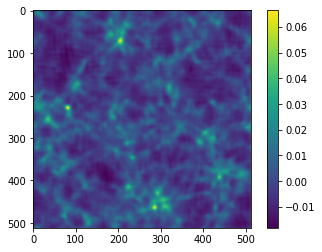

In [34]:
imshow(p);colorbar()

In [35]:
tracer = lt.simulations.RayTracer(lens_type=lt.simulations.DensityPlane)
################################################################################
#Compute the discrete comoving distances which will be the center of the lenses#
################################################################################
ps = []
for i in range(10):
    snapshot = FastPMSnapshot.open('snapshot_lensing64%d'%i)
    p,resolution,NumPart = snapshot.cutPlaneGaussianGrid(normal=2,
                                                     plane_resolution=64,   
                                                     center=(1900 - i*200)*snapshot.Mpc_over_h,
                                                     thickness=200*snapshot.Mpc_over_h,
                                                     left_corner=np.zeros(3)*snapshot.Mpc_over_h,
                                                     smooth=None,
                                                     kind='density')
    print(snapshot.header["redshift"])
    print((1900 - i*200))
    ps.append(p)
    plane = DensityPlane(p, angle=snapshot.header["box_size"],
                            redshift=snapshot.header["redshift"],
                            cosmology=Planck15,
                            num_particles=NumPart)
    tracer.addLens(plane)

[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 200. Mpc/h>]
0.7769165445672299
1900
[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 200. Mpc/h>]
0.676361400359748
1700
[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 200. Mpc/h>]
0.5816067265828684
1500
[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 200. Mpc/h>]
0.49202319903014846
1300
[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 200. Mpc/h>]
0.4070548926334576
1100
[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 200. Mpc/h>]
0.32551628261662735
900
[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 200. Mpc/h>]
0.24812079410021481
700
[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 200. Mpc/h>]
0.1740082113039223
500
[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 200. Mpc/h>]
0.10285305074925599
300
[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 200. Mpc/h>]
0.03352235926640024
100


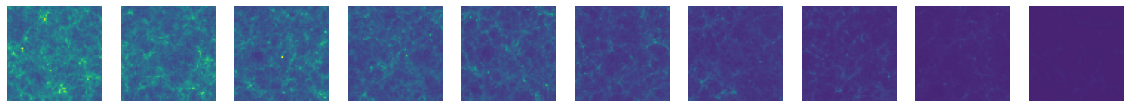

In [36]:
figure(figsize=[20,5])
for i in range(10):
    subplot(1,10,i+1)
    imshow(ps[i],vmax=0.1, vmin=-0.01)
    axis('off')

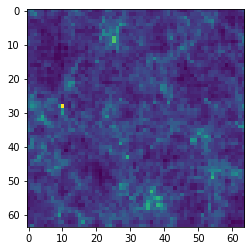

In [37]:
imshow(ps[0])

In [38]:
# Add an artificial plane at z=2 so that lenstools doesnt bother us
tracer.addLens(lt.simulations.DensityPlane(np.zeros((128,128)),
                     angle=snapshot.header["box_size"], 
                                           redshift=1.5,
                                           cosmology=Planck15))

In [39]:
# Make sure lenses are in the right order
tracer.reorderLenses()

In [40]:
tracer.distance

[<Quantity 147.19755734 Mpc>,
 <Quantity 444.14221628 Mpc>,
 <Quantity 738.1821605 Mpc>,
 <Quantity 1032.74447317 Mpc>,
 <Quantity 1327.60670181 Mpc>,
 <Quantity 1624.32987604 Mpc>,
 <Quantity 1918.6877986 Mpc>,
 <Quantity 2213.18870524 Mpc>,
 <Quantity 2507.78025755 Mpc>,
 <Quantity 2802.43131117 Mpc>,
 <Quantity 4479.04518283 Mpc>]

In [41]:
# Comparing density planes
al = tf.stack(lps_a) # Array of scale factors
rl = rad_comoving_distance(cosmo, al) # Array of comoving distances

In [42]:
constant_factor = 3 / 2 * cosmo.Omega_m * (constants.H0 / constants.c)**2

slice_width = 200. # Mpc/h
density_normalization = slice_width * rl / al

# This is the factor to apply to our lensplanes to make them LensTools compatible
factor = density_normalization*constant_factor

In [78]:
# Now normalizing densityplane
ind = 0
density = lps[ind][0]
Npart = tf.reduce_sum(density)

density = density / Npart
npix = 64
density =  density * 200.**3 / ( (200/npix) * (200/npix) *(200/1) )

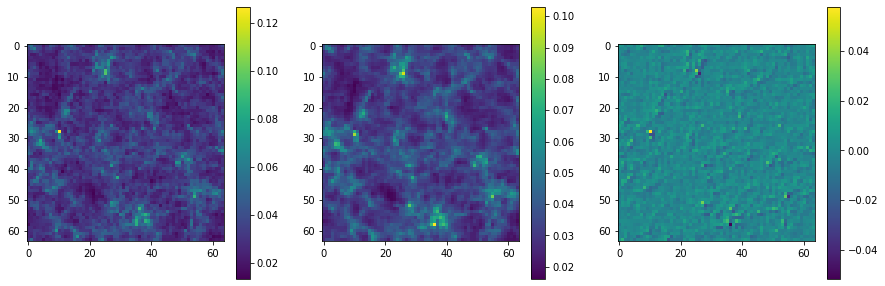

In [79]:
figure(figsize=[15,5])
subplot(131)
# This is how the lensplane looks in LensTools
imshow(ps[ind]); colorbar()
subplot(132)
# This is how the lensplane looks in LensTools
imshow(density * factor[ind]); colorbar()
subplot(133)
# This is how the lensplane looks in LensTools
imshow(ps[ind] - density * factor[ind]); colorbar()

In [80]:
# And here we compute the projection on the sky

import tensorflow_addons as tfa

In [81]:
im = tf.reshape(density*factor[0], [1, 64,64,1])

In [82]:
# Create a grid of coordinates
xgrid, ygrid = meshgrid(linspace(0,5,64, endpoint=False), # range of X coordinates
                        linspace(0,5,64, endpoint=False)) # range of Y coordinates
coords = stack([xgrid, ygrid], axis=0)*u.deg

In [83]:
# Convert angular coordinates to comoving coords
c = coords.reshape([2, -1,1]).T
c = c.to(u.rad).value*rl[ind] / (200./npix)

In [95]:
interp_im = tfa.image.interpolate_bilinear(im , c)

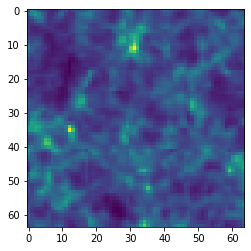

In [96]:
imshow(interp_im[0,:,0].numpy().reshape([64,64]).T)

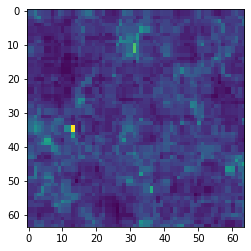

In [97]:
imshow(tracer.lens[-2].getValues(coords[0], coords[1]))

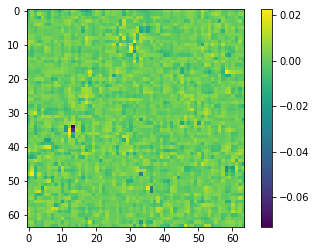

In [103]:
imshow(interp_im[0,:,0].numpy().reshape([64,64]).T - tracer.lens[-2].getValues(coords[0], coords[1])); colorbar()